In [1]:
import ee
import geemap
import json
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
ee.Authenticate()
ee.Initialize(project='ee-yuxinchen118')
Map = geemap.Map()

In [2]:
coords = [[[7.365302030814007, 45.99791113635203],
           [7.365302030814007, 45.890003655794075],
           [7.564429228079632, 45.890003655794075],
           [7.564429228079632, 45.99791113635203],
           [7.365302030814007, 45.99791113635203]]]


geometry = ee.Geometry.Polygon(coords)
center = geometry.centroid()
center_coords = center.getInfo()['coordinates']
x_center = center_coords[0]
y_center = center_coords[1]

# 25km×20km
lat_degree = 20 / 111.32  
lon_degree = 25 / (111.32 * math.cos(math.radians(y_center)))  


Aosta_region = ee.Geometry.Rectangle([
    x_center - lon_degree / 2,
    y_center - lat_degree / 2,
    x_center + lon_degree / 2,
    y_center + lat_degree / 2
])

color_scheme = {
    'water': '#419BDF',
    'trees': '#397D49',
    'grass': '#88B053',
    'shrub': '#DFC35A',
    'bare': '#A59B8F',
    'snowice': '#B39FE1'
}

classes = [ 'water', 'trees','grass','shrub','bare','snowice']
class_values = [0, 1, 2, 3, 4,5]  
palette = [color_scheme[cls] for cls in classes]

In [3]:
# Define the desired landcover class order
desired_order = [0, 1, 2, 5, 7, 8]

# Map original landcover values to new class IDs (0 to 5)
value_to_new_class = {original: i for i, original in enumerate(desired_order)}

# Load the CSV file
df = pd.read_csv('Aosta_Feature_Collection.csv')

# Filter to keep only the desired landcover classes
df = df[df['landcover'].isin(desired_order)]

# Sort rows according to the specified order
df['sort_key'] = df['landcover'].apply(lambda x: desired_order.index(x))
df = df.sort_values(by='sort_key').drop(columns='sort_key')

# Map original landcover values to new class IDs
df['class'] = df['landcover'].map(value_to_new_class)

# Convert to an Earth Engine FeatureCollection
training_features = []
for _, row in df.iterrows():
    geom_dict = json.loads(row['.geo'])
    geometry = ee.Geometry(geom_dict)
    landcover_class = int(row['class'])  # New class ID (0 to 5)
    feature = ee.Feature(geometry, {'class': landcover_class})
    training_features.append(feature)

training_fc = ee.FeatureCollection(training_features)

In [4]:
image_id = "20221006T102949_20221006T103655_T32TLR"
sentinel_image = ee.Image("COPERNICUS/S2_SR/" + image_id)

# select bands
selected_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

# clip
image = sentinel_image.select(selected_bands).clip(Aosta_region)


ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
bsi = image.expression(
    '((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))', {
        'B11': image.select('B11'),
        'B4': image.select('B4'),
        'B8': image.select('B8'),
        'B2': image.select('B2')
    }
).rename('BSI')


composite = image.resample('bicubic') \
                 .addBands([ndvi, ndwi, ndbi, bsi])

all_bands = selected_bands + ['NDVI', 'NDWI', 'NDBI', 'BSI']

# add additional bands
rendvi = image.normalizedDifference(['B8', 'B5']).rename('RENDVI')


evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B8'),
        'RED': image.select('B4'),
        'BLUE': image.select('B2')
    }
).rename('EVI')

savi = image.expression(
    '((NIR - RED) / (NIR + RED + 0.5)) * 1.5', {
        'NIR': image.select('B8'),
        'RED': image.select('B4')
    }
).rename('SAVI')


composite = composite.addBands([rendvi, evi, savi])
all_bands = all_bands + ['RENDVI', 'EVI', 'SAVI']


Map.centerObject(Aosta_region, 10)
Map.addLayer(image.select(['B4', 'B3', 'B2']), 
             {'min': 0, 'max': 3000}, 'Original True Color Image')

In [5]:
# Count number of classes and print sample counts
n_classes = training_fc.aggregate_array('class').distinct().size().getInfo()
for i in range(n_classes):
    count = training_fc.filter(ee.Filter.eq('class', i)).size().getInfo()
    print(f"Class {i} sample count: {count}")

# Split dataset: 70% training, 30% validation
with_random = training_fc.randomColumn('random')
train_fc = with_random.filter(ee.Filter.lt('random', 0.7))
val_fc = with_random.filter(ee.Filter.gte('random', 0.7))
print("Training samples:", train_fc.size().getInfo())
print("Validation samples:", val_fc.size().getInfo())

Class 0 sample count: 20
Class 1 sample count: 47
Class 2 sample count: 38
Class 3 sample count: 31
Class 4 sample count: 73
Class 5 sample count: 65
Training samples: 196
Validation samples: 78


In [6]:
# Sample image using training and validation points
train_data = composite.sampleRegions(collection=train_fc, properties=['class'], scale=10, geometries=True)
val_data = composite.sampleRegions(collection=val_fc, properties=['class'], scale=10, geometries=True)

# Train Random Forest classifier
classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=100, 
    seed=42, 
    minLeafPopulation=10, 
    bagFraction=0.7
).train(features=train_data, classProperty='class', inputProperties=all_bands)

# Apply classifier
classified = composite.classify(classifier)

In [7]:
# Visualize results on map
Map.centerObject(Aosta_region, 10)
Map.addLayer(image.select(['B4', 'B3', 'B2']), {'min': 0, 'max': 3000}, 'True Color')
Map.addLayer(classified, {'min': 0, 'max': n_classes - 1, 'palette': palette}, 'Aosta RF')

# Add legend
Map.add_legend(title="Land Cover Types", 
    legend_dict={
    'water': '#419BDF',
    'trees': '#397D49',
    'grass': '#88B053',
    'shrub': '#DFC35A',
    'bare': '#A59B8F',
    'snowice': '#B39FE1',
})

# Display map
display(Map)

Map(center=[45.944048321490826, 7.464865629445187], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
import ee
from pathlib import Path

def export_aosta_classification(classified):

    # 2. 裁剪并转换为整数类型（用于 GeoTIFF 导出）
    classified_clipped = classified.clip(Aosta_region).byte()

    # 3. 创建导出任务
    task = ee.batch.Export.image.toDrive(
        image=classified_clipped,
        description='aosta_rf_classification_raw',
        folder='Mapresult',       # Drive 文件夹名
        fileNamePrefix='Aosta_RF_Classification',  # 文件名前缀
        region=Aosta_region,
        scale=30,
        crs='EPSG:4326',
        fileFormat='GeoTIFF',
        maxPixels=1e9
    )

    # 4. 启动任务
    task.start()
    print("✅ 导出任务已启动！请稍候检查 Google Drive 中的 EarthEngine_Exports 文件夹。")
    return task

# ✅ 调用函数
export_task = export_aosta_classification(classified)

✅ 导出任务已启动！请稍候检查 Google Drive 中的 EarthEngine_Exports 文件夹。


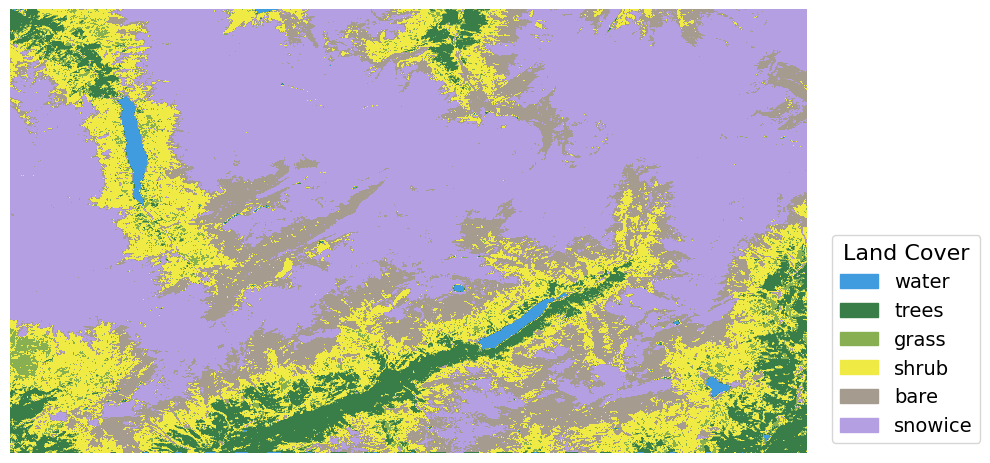

In [9]:

import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# 类别颜色定义
color_scheme = {
    'water': '#419BDF',
    'trees': '#397D49',
    'grass': '#88B053',
    'shrub': '#F0EA45',
    'bare': '#A59B8F',
    'snowice': '#B39FE1'
}
palette = list(color_scheme.values())
classes = list(color_scheme.keys())

# 读取 RF 分类 tif
with rasterio.open('Aosta_RF_Classification.tif') as src:
    rf_image = src.read(1)

# 绘图
plt.figure(figsize=(10, 10))
cmap = plt.matplotlib.colors.ListedColormap(palette)
plt.imshow(rf_image, cmap=cmap, vmin=0, vmax=5)
plt.axis('off')

# 图例右下角外部
legend_patches = [Patch(color=palette[i], label=classes[i]) for i in range(len(classes))]
plt.legend(
    handles=legend_patches,
    title="Land Cover",
    loc='lower left',
    bbox_to_anchor=(1.02, 0),
    frameon=True,
    fontsize=14,
    title_fontsize=16
)

plt.tight_layout()
plt.savefig("psAosta_RF_Classification_with_Legend.png", dpi=300, bbox_inches='tight')
plt.show()

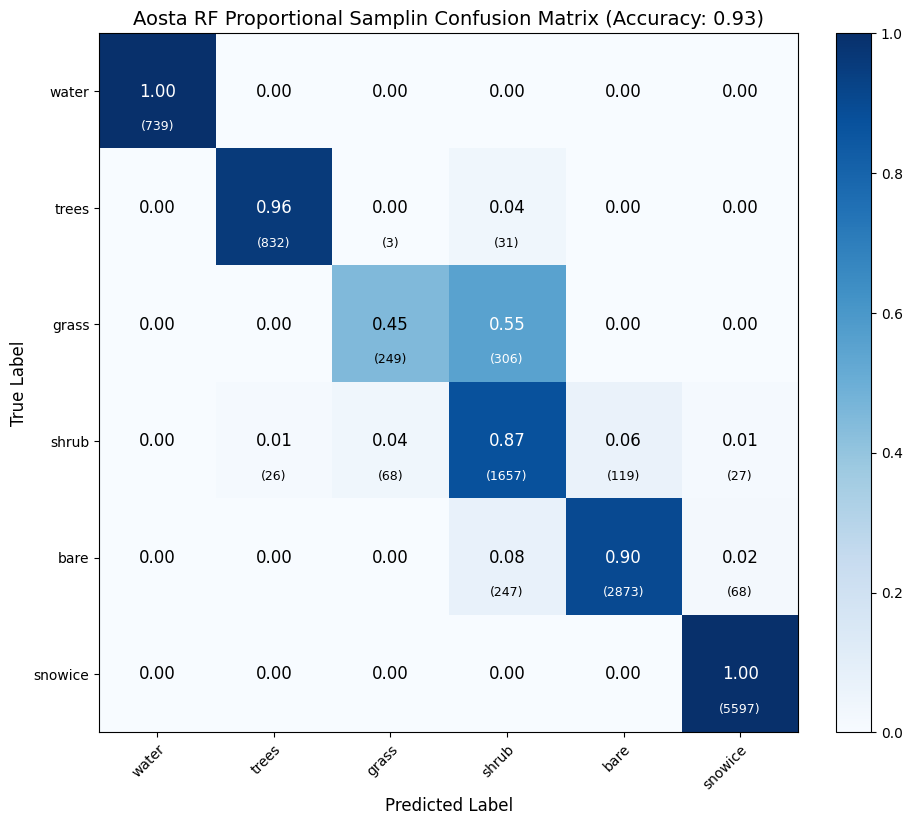

In [8]:
validation = val_data.classify(classifier)
confusion_matrix = validation.errorMatrix('class', 'classification')

def plot_ee_confusion_matrix(confusion_matrix, class_names=None):
    cm_array = np.array(confusion_matrix.array().getInfo())
    accuracy = confusion_matrix.accuracy().getInfo()
    if class_names is None:
        n_classes = cm_array.shape[0]
        class_names = [str(i) for i in range(n_classes)]
    cm_normalized = np.zeros(cm_array.shape)
    for i in range(cm_array.shape[0]):
        row_sum = np.sum(cm_array[i, :])
        if row_sum > 0:
            cm_normalized[i, :] = cm_array[i, :] / row_sum
    
    fig, ax = plt.subplots(figsize=(10, 8))

    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    
    ax.set_title(f'Aosta RF Proportional Samplin Confusion Matrix (Accuracy: {accuracy:.2f})', fontsize=14)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
   
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            # Show normalized value
            ax.text(j, i, f"{cm_normalized[i, j]:.2f}",
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > 0.5 else "black",
                    fontsize=12)
            
            # Show raw sample count in parentheses
            if cm_array[i, j] > 0:
                ax.text(j, i + 0.3, f"({int(cm_array[i, j])})",
                        ha="center", va="center",
                        color="white" if cm_normalized[i, j] > 0.5 else "black",
                        fontsize=9)
    
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    return fig, ax


class_names = ['water', 'trees','grass','shrub','bare','snowice']

fig, ax = plot_ee_confusion_matrix(confusion_matrix, class_names)

plt.show()